In [1]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam,SGD
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose,BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
import glob
import numpy as np
import cv2
from numpy import asarray
import matplotlib.pyplot as plt
import re
import random
import tensorflow as tf
import scipy.spatial.distance as d
from SpectralNormalizationKeras import DenseSN
from instance import InstanceNormalization

def read_fvector(filePath):
    with open(filePath) as f:
        for line in f.readlines():
            return np.fromstring(line,sep = ",")


CLASSES = 297
BATCH = 356
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts



# define the standalone discriminator model
def define_discriminator(in_shape=(1024,), n_classes=CLASSES):

    
#     in_label = Input(shape=(1,))

    in_fv = Input(shape=(1024,))
    # embedding for categorical input
#     li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
#     n_nodes = in_shape[0] * in_shape[1]

#     label_dense = Dense(64)(in_label)
#     label_dense = LeakyReLU(alpha=0.2)(label_dense)

    li = DenseSN(16)(in_fv)

    
    # reshape to additional channel
#     li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # image input
#     in_image = Input(shape=in_shape)
    # concat label as a channel0
#     merge = Concatenate()([label_dense, li])
    # downsample
#     fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(li)
#     fe = BatchNormalization()(fe)

    # downsample
#     fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = DenseSN(128)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    
#     fe = Conv2D(128, (7,7), strides=(2,2))(fe)
#     fe = LeakyReLU(alpha=0.1)(fe)
#     fe = BatchNormalization()(fe)

    # flatten feature maps
#     fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = DenseSN(1, activation='tanh')(fe)
    # define model
    model = Model([in_fv], out_layer)
    # compile model
    opt = Adam(lr=0.00025)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    print(model.summary())

    return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=CLASSES):
    # label input
#     in_fv = Input(shape=(1024,))
    # embedding for categorical input
#     li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
#     n_nodes = 32
#     li = Dense(64)(in_fv)
    # reshape to additional channel
#     li = Reshape((16, 2, 1))(li)
    # image generator input
#     in_label = Input(shape=(1,))
#     label_dense = Dense(64)(in_label)

    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
#     n_nodes = 64 * 2 * 16
    gen = DenseSN(64)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
#     gen = Reshape((16, 2, 64))(gen)
    # merge image gen and label input
#     merge = Concatenate()([gen, label_dense])
    # upsample to 14x14
#     gen = Conv2DTranspose(64, (4,4), strides=(4,4), padding='same')(merge)
    gen = DenseSN(128)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = BatchNormalization()(gen)

    gen = DenseSN(64)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = BatchNormalization()(gen)

#     gen = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')(gen)
#     gen = LeakyReLU(alpha=0.2)(gen)
#     gen = BatchNormalization()(gen)


#     gen = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')(gen)
#     gen = Flatten()(gen)
    out_layer = DenseSN(1024,activation = 'tanh')(gen)
    out_layer = Dropout(0.5)(out_layer)
#     gen = Flatten()
#     gen = Dense(1024,activation = 'tanh')

    # output
#     out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    # define model
    model = Model([in_lat], out_layer)
    print(model.summary())
    
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model(gen_output)
    # define gan model as taking noise and label and outputting a classification
    model = Model(gen_noise, gan_output)
    # compile model
    opt = Adam(lr=0.00029)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    print(model.summary())
    return model


# # select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
#     print(dataset)
    fv = next(dataset)
    # choose random instances
#     ix = randint(0, images.shape[0], n_samples)
#     # select images and labels
#     X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return fv, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=CLASSES):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
#     labels = randint(0, n_classes, n_samples)
    return z_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input = generate_latent_points(latent_dim, n_samples)
#     print (z_input.shape)
#     z_input = x_input.reshape(n_samples, latent_dim)

    # predict outputs
    images = generator.predict([z_input])
    # create class labels
    y = zeros((n_samples, 1))
    return images, y

folderList = sorted(glob.glob('/home/sohaib/.work/Template Generation/ndR_template_folders/*'),key=numericalSort)

def customGenerator():
    BATCH_SIZE = 1

    
    while True:
        if_perturb = random.sample(range(10), 1)[0]

        xI = np.zeros(shape = (BATCH,1024))
        num_folder = random.sample(range(len(folderList)), BATCH)

        for x in range(len(num_folder)):

            fv_list = sorted(glob.glob(folderList[num_folder[x]] + "/*"),key=numericalSort)
            num_fv = random.sample(range(len(fv_list)), 1)

            y2 = np.zeros(shape = (1),dtype = np.int32)
            fv = read_fvector(fv_list[num_fv[0]])
            if if_perturb>7 :
                num_zero = random.sample(range(1024), 10)
                for y in range(len(num_zero)):
                    fv[num_zero[y]] = 0

#             numFm = random.sample(range(len(folderList)), BATCH_SIZE)


#             fv = fv-1
            xI[x] = fv
#         yI = np.einsum('abcd->adcb',yI)
        yield (xI)

def check_Templates(templates,tanh = True):
#     print (templates.shape[0])
    if(tanh):
#         templates = templates + 1
        templates[templates<0] = 0
        templates[templates>0] = 1
    cdist = np.zeros(shape = (templates.shape[0],templates.shape[0]))
#     cdist = (d.cdist(templates,templates,metric='hamming'))
    for x in range(templates.shape[0]):
        for y in range(templates.shape[0]):
            cdist[x][y] = d.hamming(templates[x],templates[y])
    return cdist


# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=90, n_batch=BATCH):
#     bat_per_epo = int(dataset[0].shape[0] / n_batch)
    bat_per_epo = int(50)
#     tf.keras.utils.plot_model(g_model,to_file="gModel.png",show_shapes = True)
#     tf.keras.utils.plot_model(d_model,to_file="dModel.png",show_shapes = True)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, BATCH)
        dist = check_Templates(X_fake)
        print (i,np.mean(dist))

        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, BATCH)
            #Showing correct loading of dataset
#             imtoShow = np.einsum('abcd->adcb',X_real)
#             plt.imshow(imtoShow[0][0]),plt.show()
#             print ("Label = " + str(labels_real[0]))
#             print (X_real.shape)
            # update discriminator model weights
    
            d_model.trainable = True
            gan_model.trainable = False
            g_model.trainable = False

            d_loss1, acc1 = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, BATCH)
            # update discriminator model weights
            d_loss2, acc2 = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            z_input = generate_latent_points(latent_dim, BATCH)
            # create inverted labels for the fake samples
            y_gan = ones((BATCH, 1))
            # update the generator via the discriminator's error
            d_model.trainable = False
            gan_model.trainable = True
            g_model.trainable = True
            g_loss = gan_model.train_on_batch(z_input, y_gan)
            # summarize loss on this batch
#             print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f acc1=%.3f acc2=%.3f' %
#                 (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss,acc1,acc2))  
#         latent_points, labels = generate_latent_points(latent_dim, 1)
#         labels = asarray([0])
#         X  = g_model.predict([latent_points, labels])
#         X = (X + 1) / 2.0

#         plt.imshow(X[0,:,:,0].T,cmap = 'gray'),plt.show()
        
#         latent_points, labels = generate_latent_points(latent_dim, 1)
#         labels = asarray([23])
#         X  = g_model.predict([latent_points, labels])
#         X = (X + 1) / 2.0
#         plt.imshow(X[0,:,:,0].T,cmap = 'gray'),plt.show()
        # save the generator model
        g_model.save('cgan_generator.h5')




# size of the latent space
latent_dim = 128
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = customGenerator()

# dataset = load_real_samples()
# # train model
train(g_model, d_model, gan_model, dataset, latent_dim)



    #     print (X.shape)
    #     scale from [-1,1] to [0,1]
    #     X = (X + 1) / 2.0

print ("End of cell")




Using TensorFlow backend.
/home/sohaib/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sohaib/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sohaib/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sohaib/.local/lib/python3.7/site-packages/tensorflow/python

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
dense_sn_1 (DenseSN)         (None, 16)                16416     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_sn_2 (DenseSN)         (None, 128)               2304      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)  

In [4]:
a = next(dataset)

print (a[0])

X_fake, y_fake = generate_fake_samples(g_model, latent_dim, 16)

print (X_fake)

[-0.02645431  0.03109779 -0.03575617 ...  0.05147869  0.04410387
  0.01219403]
[[-0.00097495  0.00520921 -0.02667504 ...  0.01275418  0.02677728
  -0.00187786]
 [ 0.00443691  0.00175229 -0.03022394 ...  0.0226205  -0.00111438
  -0.01815374]
 [-0.04187949 -0.02281537 -0.00736826 ...  0.08901814 -0.05432573
   0.00206119]
 ...
 [-0.03669741 -0.01680968  0.00174545 ... -0.01933853 -0.01415331
  -0.0038146 ]
 [-0.01275508  0.01800206 -0.00376476 ...  0.041034    0.06526588
   0.01355601]
 [-0.04989658  0.01501771  0.0219632  ...  0.02155265 -0.00044785
   0.00403468]]


-0.0046120374
-0.0028528878831122206
(16, 1024)
-0.00048540067
0.37575531005859375
-0.0020289933
0.39492994726735103
-0.00066086807
-0.0023047247
-0.0019307805
-0.0023215862
-0.0027498342
-0.0014139004
-0.0023439254
-0.0016390568
-0.0027851553
-0.0020158193
-0.0022797028
-0.0016381408
-0.0014848756
-0.0015798924
-0.003913914
-0.0042379275
-0.0012950875
-0.0022395146
-0.0009902779
-0.002316813
-0.000979775
-0.0026250442
-0.0025462774
-0.0018273942
-0.0045771888
-0.0024325803
-0.0010458708
-0.0023094532
0.00050789496
-0.0023637763
-0.0035469343
-0.0026021074
-0.00015986757
-0.0006781632
-0.0009402337
-0.002316972
-0.0027544242
-0.0022236386
-0.0036099008
-0.0030430094
-0.0021863827
-0.001956025
-0.002325505
-0.001364271
-0.0005781634
-0.0004521443
-0.003938569
-0.002424659
-0.0014133229
-0.0011012056
-0.0018570006
-0.0017092165
-0.0017389159
-0.0021160964
-0.0015405684
-0.001647273
-0.001451341
-0.0019639905
-0.002260795
-0.0017940208
-0.0025880067
-0.0014814604
-0.0034741391
-0.00314643

[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[1. 0. 0. ... 0. 1. 1.] (16, 1024)
[1. 0. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 0. ... 0. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 0. 0. ... 1. 1. 0.] (16, 1024)
[1. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 0. 0. 1.] (16, 1024)
[0. 0. 0. ... 0. 1. 0.] (16, 1024)
[0. 0. 1. ... 0. 0. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 0. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[1. 1. 0. ... 0. 0. 1.] (16, 1024)
[0. 0. 0. ... 1. 1. 0.] (16, 1024)
[1. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 0. 0. 1.] (16, 1024)
[0. 1. 0. ... 0. 1. 

[0. 0. 1. ... 0. 0. 0.] (16, 1024)
[1. 0. 0. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[1. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 0. 1. 0.] (16, 1024)
[0. 1. 0. ... 0. 1. 0.] (16, 1024)
[0. 1. 0. ... 0. 0. 1.] (16, 1024)
[0. 0. 1. ... 0. 0. 0.] (16, 1024)
[0. 0. 1. ... 0. 1. 1.] (16, 1024)
[0. 1. 0. ... 1. 1. 1.] (16, 1024)
[1. 0. 1. ... 1. 0. 0.] (16, 1024)
[1. 1. 1. ... 0. 1. 1.] (16, 1024)
[0. 0. 0. ... 0. 1. 1.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 0. ... 0. 0. 1.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 0. 1. 1.] (16, 1024)
[0. 1. 0. ... 1. 0. 1.] (16, 1024)
[0. 0. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[1. 0. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 0. 0. 1.] (16, 1024)
[0. 1. 0. ... 0. 0. 0.] (16, 1024)
[1. 0. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 0. 

[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[1. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[1. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[1. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 0. 0. ... 1. 0. 1.] (16, 1024)
[0. 0. 0. ... 1. 0. 1.] (16, 1024)
[0. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[1. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[0. 0. 0. ... 1. 0. 1.] (16, 1024)
[0. 0. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[0. 0. 1. ... 1. 1. 

[0. 0. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 0. 0. 1.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 1.] (16, 1024)
[1. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[1. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 0. 0. ... 1. 0. 0.] (16, 1024)
[1. 0. 0. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 0. 0. ... 1. 0. 0.] (16, 1024)
[0. 0. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[1. 1. 1. ... 1. 0. 1.] (16, 1024)
[0. 0. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 0. ... 0. 1. 

[1. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[1. 0. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 0. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 1.] (16, 1024)
[0. 1. 0. ... 1. 0. 1.] (16, 1024)
[1. 1. 0. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 0. 1.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 0. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 

[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 1.] (16, 1024)
[1. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 1.] (16, 1024)
[0. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[1. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 1.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[1. 0. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 0. ... 0. 1. 1.] (16, 1024)
[1. 0. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 0. 0. ... 1. 0. 1.] (16, 1024)
[0. 1. 0. ... 0. 1. 0.] (16, 1024)
[1. 0. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[0. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 0. ... 0. 0. 

[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[1. 1. 0. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[1. 1. 0. ... 0. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[1. 1. 1. ... 1. 1. 0.] (16, 1024)
[1. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[1. 1. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 1.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[0. 0. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 1.] (16, 1024)
[1. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 

[1. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[1. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 0. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 0. 1. 0.] (16, 1024)
[0. 0. 0. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 0. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 1.] (16, 1024)
[1. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[1. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 

[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[1. 0. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 0. 0. 0.] (16, 1024)
[1. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 1.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 0. 1. ... 0. 0. 0.] (16, 1024)
[0. 0. 1. ... 0. 0. 1.] (16, 1024)
[0. 0. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 0. ... 0. 0. 0.] (16, 1024)
[1. 1. 1. ... 1. 0. 1.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[1. 1. 0. ... 1. 1. 1.] (16, 1024)
[1. 1. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 1.] (16, 1024)
[0. 0. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 

[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 0. 0. 1.] (16, 1024)
[0. 0. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[1. 0. 0. ... 1. 0. 0.] (16, 1024)
[1. 1. 0. ... 0. 1. 0.] (16, 1024)
[0. 0. 1. ... 0. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 0. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[1. 1. 0. ... 1. 0. 1.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 0. 1. ... 0. 1. 0.] (16, 1024)
[1. 0. 0. ... 0. 0. 1.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 0. 0. ... 1. 0. 1.] (16, 1024)
[1. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[1. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 

[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[1. 1. 1. ... 1. 1. 0.] (16, 1024)
[1. 0. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[0. 0. 1. ... 1. 1. 0.] (16, 1024)
[0. 0. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[1. 1. 0. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[1. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[1. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 0. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 

[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 1.] (16, 1024)
[1. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 0. ... 1. 1. 1.] (16, 1024)
[1. 0. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[1. 1. 0. ... 1. 0. 1.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 0. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 1.] (16, 1024)
[0. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 

[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[0. 0. 0. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 0. ... 1. 0. 1.] (16, 1024)
[0. 0. 1. ... 0. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 1.] (16, 1024)
[1. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 0. ... 0. 1. 0.] (16, 1024)
[0. 0. 1. ... 0. 1. 0.] (16, 1024)
[0. 0. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[1. 0. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 

[1. 0. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 0. ... 0. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 0. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[1. 1. 1. ... 0. 1. 1.] (16, 1024)
[0. 0. 0. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 0. 0. 0.] (16, 1024)
[1. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 0. 1. 1.] (16, 1024)
[0. 0. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[1. 0. 0. ... 1. 1. 1.] (16, 1024)
[1. 0. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[1. 1. 0. ... 0. 1. 0.] (16, 1024)
[1. 0. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 1.] (16, 1024)
[0. 1. 0. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 

[1. 0. 0. ... 1. 0. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[1. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[1. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 0. ... 1. 1. 1.] (16, 1024)
[1. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 0. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 0. 0. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[1. 0. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 0. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 0. ... 1. 1. 1.] (16, 1024)
[1. 1. 0. ... 1. 0. 1.] (16, 1024)
[0. 0. 0. ... 1. 1. 

[0. 0. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 1.] (16, 1024)
[0. 0. 0. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[1. 0. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[1. 1. 0. ... 0. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 0. 0. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[0. 1. 1. ... 0. 0. 1.] (16, 1024)
[1. 1. 1. ... 1. 1. 1.] (16, 1024)
[1. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 1.] (16, 1024)
[1. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 0. ... 1. 1. 

[0. 0. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[1. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[0. 0. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[1. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 0. ... 1. 1. 1.] (16, 1024)
[0. 0. 0. ... 1. 0. 0.] (16, 1024)
[1. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 0. 0. ... 1. 0. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[1. 1. 0. ... 0. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 

[0. 1. 1. ... 1. 0. 1.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 1.] (16, 1024)
[1. 0. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[1. 0. 0. ... 0. 0. 0.] (16, 1024)
[1. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 0. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 0. 0. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 0. ... 0. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 0.] (16, 1024)
[0. 0. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 0.] (16, 1024)
[1. 1. 0. ... 0. 1. 

[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 0. ... 1. 0. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 1. 1. 0.] (16, 1024)
[1. 0. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[0. 0. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 0. ... 1. 0. 1.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[1. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[1. 1. 0. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[1. 1. 0. ... 1. 0. 

[1. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 1.] (16, 1024)
[1. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 0. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 0. ... 1. 0. 0.] (16, 1024)
[0. 0. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 0. 0. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[1. 1. 0. ... 1. 0. 1.] (16, 1024)
[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[1. 1. 0. ... 0. 1. 1.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[1. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 0.] (16, 1024)
[1. 1. 0. ... 0. 1. 1.] (16, 1024)
[1. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[1. 0. 0. ... 1. 1. 

[0. 0. 1. ... 0. 0. 1.] (16, 1024)
[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 1.] (16, 1024)
[1. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 0. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[1. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 0. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 0.] (16, 1024)
[1. 0. 1. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 0. 1. 1.] (16, 1024)
[1. 0. 0. ... 0. 0. 0.] (16, 1024)
[0. 0. 0. ... 1. 0. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 0. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[1. 0. 1. ... 0. 1. 

[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[1. 1. 0. ... 1. 0. 0.] (16, 1024)
[1. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 0. 1. 1.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[1. 0. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 1.] (16, 1024)
[1. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 1.] (16, 1024)
[1. 1. 0. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[1. 0. 0. ... 1. 0. 

[0. 1. 0. ... 1. 0. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[0. 0. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 1. 0. 1.] (16, 1024)
[0. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 0. 0. ... 1. 0. 1.] (16, 1024)
[0. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[1. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 0. ... 1. 1. 1.] (16, 1024)
[1. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 0. 1. 

[0. 1. 1. ... 1. 0. 1.] (16, 1024)
[1. 0. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[1. 1. 0. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 0. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 0. ... 0. 0. 0.] (16, 1024)
[0. 1. 0. ... 0. 0. 1.] (16, 1024)
[0. 1. 0. ... 0. 0. 0.] (16, 1024)
[1. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 1.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 0. 0. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[1. 1. 0. ... 1. 1. 0.] (16, 1024)
[1. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 

[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[1. 1. 0. ... 0. 0. 0.] (16, 1024)
[1. 1. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 0. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 0. 1. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 1. 1. 1.] (16, 1024)
[0. 1. 0. ... 0. 1. 0.] (16, 1024)
[0. 1. 0. ... 1. 0. 0.] (16, 1024)
[1. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[1. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 1.] (16, 1024)
[1. 1. 0. ... 1. 1. 1.] (16, 1024)
[0. 0. 1. ... 1. 0. 1.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 1. 0. 0.] (16, 1024)
[0. 0. 1. ... 1. 0. 0.] (16, 1024)
[0. 1. 1. ... 0. 1. 0.] (16, 1024)
[0. 1. 1. ... 1. 1. 0.] (16, 1024)
[0. 0. 1. ... 0. 0. 0.] (16, 1024)
[0. 0. 0. ... 1. 0. 

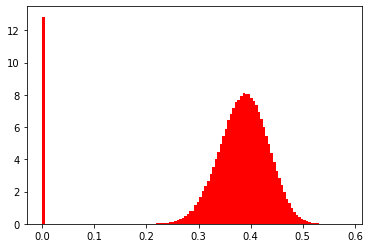

In [6]:
X_fake, y_fake = generate_fake_samples(g_model, latent_dim, 16)
a = next(dataset)


print (np.mean(X_fake[0]))
print (np.mean(a[0]))


print (X_fake.shape)
def check_Templates(templates,tanh = True):
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, 16)
    print (np.mean(X_fake[0]))

#     print (templates.shape[0])
    if(tanh):
#         templates = templates + 1
        templates[templates<0] = 0
        templates[templates>0] = 1
    cdist = np.zeros(shape = (templates.shape[0],templates.shape[0]))
#     cdist = (d.cdist(templates,templates,metric='hamming'))
    for x in range(templates.shape[0]):
        for y in range(templates.shape[0]):
            cdist[x][y] = d.hamming(templates[x],templates[y])
    return cdist
dist = check_Templates(X_fake)
# print (dist)
print (np.mean(dist))
dist = check_Templates(a)
# print (dist)
print (np.mean(dist))

avg_dist = 0
for x in range(100):
    dist = check_Templates(X_fake)
    avg_dist += np.mean(dist)
print (avg_dist)

distances = []
K = 6000
for x in range(K):
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, 16)
    X_fake[X_fake<0] = 0
    X_fake[X_fake>0] = 1

    print(X_fake[0],X_fake.shape)
    X_fake = X_fake.astype(np.uint8)
    for y in range(X_fake.shape[0]):

        fileName = str((x*16) + y) +"d"+str("834g")
        fetFile = open("/home/sohaib/.work/Template Generation/Generated Templates/" + fileName, 'w+')
        for item in X_fake[y]:
            fetFile.write("%s," % item)
        fetFile.close()
    for x in range(X_fake.shape[0]):
        for y in range(X_fake.shape[0]):
            distances.append(d.hamming(X_fake[x],X_fake[y]))

#     print (len(distances))

plt.hist(distances, density=True, bins=120, histtype='stepfilled', color='r', label='Different')
plt.show()
